In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbs
from tokenizers import Tokenizer

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BartConfig, BartModel, PreTrainedTokenizerFast
from torch.optim import AdamW

from transformers import BartConfig, BartModel, PreTrainedTokenizerFast
from tqdm import tqdm
import random

/home/jeongyuseong/anaconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def apply_infilling_masking(text, mask_token="<mask>", mask_prob=0.15, max_mask_size=3):
    """
    Infilling Masking을 적용하는 함수.
    
    Args:
        text (str): 원본 텍스트
        mask_token (str): 마스킹 토큰 (디폴트: <mask>)
        mask_prob (float): 토큰을 마스킹할 확률 (디폴트: 0.15)
        max_mask_size (int): 최대 연속 마스킹 토큰 수 (디폴트: 3)

    Returns:
        str: 마스킹된 텍스트
    """
    # 텍스트를 공백 기준으로 토큰화
    tokens = text.split()

    # 마스킹 대상 토큰 선택
    num_masks = max(1, int(len(tokens) * mask_prob))
    mask_positions = random.sample(range(len(tokens)), num_masks)

    # 마스킹 적용
    for pos in mask_positions:
        mask_length = random.randint(1, max_mask_size)  # 연속 마스크 길이
        tokens[pos:pos + mask_length] = [mask_token]

    # 마스킹된 텍스트 반환
    return " ".join(tokens)


In [3]:
test_path = 'datas/test.csv'
train_path = 'datas/train.csv'

test_pd = pd.read_csv(test_path)
train_pd = pd.read_csv(train_path)

# 가장 긴 생성할 테스트 난독화 텍스트 길이 : 1965
# 두 문장 모두 최대길이는 1381 1381
train_text = list(train_pd['input'])
masked_text = [apply_infilling_masking(x) for x in train_text]
textGT = list(train_pd['output'])


In [4]:
# 저장된 토크나이저 로드
tokenizer = Tokenizer.from_file("tokenizers/BPE_tokenizer_50000.json")
text_sample =  '별 한 게토 았깝땀. 왜 싸람듯릭 펼 1캐를 쥰눈징 컥꺾폰 싸람믐롯섞 맒록 섧멍핥쟈닐 탯끎룐눈 녀뮤 퀼교... 야뭍툰 둠 변 닺씨 깍낄 싫훈 굣. 깸삥읊 20여 년 댜녁뵨 곧 중 쩨윌 귑푼 낙팠떤 곶.'
# 테스트
input_encoded = tokenizer.encode(text_sample)
print("토큰화 결과:", input_encoded.tokens)

토큰화 결과: ['별', '한', '게토', '았깝', '땀', '.', '왜', '싸람', '듯', '릭', '펼', '1캐', '를', '쥰눈', '징', '컥', '꺾', '폰', '싸람', '믐', '롯', '섞', '맒록', '섧멍', '핥', '쟈', '닐', '탯', '끎룐눈', '녀뮤', '퀼', '교', '...', '야뭍', '툰', '둠', '변', '닺씨', '깍', '낄', '싫훈', '굣', '.', '깸삥', '읊', '20', '여', '년', '댜녁', '뵨', '곧', '중', '쩨윌', '귑푼', '낙', '팠', '떤', '곶', '.']


In [5]:
class EncoderDataset(Dataset):
    """
    inputs ('str' list): Text infilling된 난독화 텍스트 리스트
    targets ('str' list): 원본 난독화 텍스트 리스트
    tokenizer : 커스텀 토크나이저 (BPE, WordPiece 등)
    max_len : 원본 문자열 최대 길이
    """
    def __init__(self, inputs, targets, tokenizer, max_len):
        self.inputs = inputs
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        input_text = self.inputs[index]
        target_text = self.targets[index]

        # 입력 텍스트 토큰화 (타겟 텍스트는 별도로 사용 안 함)
        input_encoded = self.tokenizer.encode(input_text)
        target_encoded = self.tokenizer.encode(target_text)

        # 토큰 ID와 패딩 적용
        input_ids = input_encoded.ids
        target_ids = target_encoded.ids
        attention_mask = [1] * len(input_ids)

        # 시퀀스 길이 조정
        if len(input_ids) < self.max_len:
            # 패딩 추가
            pad_length = self.max_len - len(input_ids)
            target_pad_length = self.max_len - len(target_ids)
            input_ids += [self.tokenizer.token_to_id("<pad>")] * pad_length
            target_ids += [self.tokenizer.token_to_id("<pad>")] * target_pad_length
            attention_mask += [0] * pad_length
        else:
            # 길이 초과 시 자르기
            input_ids = input_ids[:self.max_len]
            target_ids = target_ids[:self.max_len]
            attention_mask = attention_mask[:self.max_len]

        # 텐서로 변환
        input_ids = torch.tensor(input_ids, dtype=torch.long)
        target_ids = torch.tensor(target_ids, dtype=torch.long)
        attention_mask = torch.tensor(attention_mask, dtype=torch.long)

        return {
            "input_ids": input_ids.squeeze(0),
            "attention_mask": attention_mask.squeeze(0),
            "labels": target_ids.squeeze(0)
        }

In [6]:
dataset = EncoderDataset(masked_text, train_text, tokenizer=tokenizer, max_len=2000)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

batchiter = iter(dataloader)
batch = next(batchiter)
print(batch['input_ids'])
print(batch['attention_mask'])
print(batch['labels'])

tensor([[ 6977,  2581,    17,  ...,     0,     0,     0],
        [34007,    17,  1519,  ...,     0,     0,     0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([[ 6977,  2581,    17,  ...,     0,     0,     0],
        [34007,    17,  1519,  ...,     0,     0,     0]])


In [7]:
# 1031
config = BartConfig(
    vocab_size=tokenizer.get_vocab_size(),
    d_model=512,
    encoder_layers=3,
    encoder_attention_heads=4,
    max_position_embeddings=2000
)
model = BartModel(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
batchiter = iter(dataloader)
batch = next(batchiter)

model.to(device)
input_ids = batch['input_ids'].to(device)
attention_mask = batch['attention_mask'].to(device)
labels = batch['labels'].to(device)
print(input_ids.shape)
print(attention_mask.shape)
print(labels.shape)

# 선형 레이어 추가
vocab_size = tokenizer.get_vocab_size()  # 예시 vocab_size
linear_layer = nn.Linear(512, vocab_size).to(device)

# 모델 출력 후 변환
outputs = model.encoder(input_ids=input_ids, attention_mask=attention_mask)
logits = outputs.last_hidden_state  # torch.Size([2, 2000, 512])
print(logits.shape)

# 선형 변환을 통해 logits 크기 조정
logits = linear_layer(logits)  # torch.Size([2, 2000, vocab_size])
print(logits.shape)

# 손실 계산을 위한 형태 변환
logits = logits.view(-1, vocab_size)  # torch.Size([4000, vocab_size])
print(logits.shape)
labels = labels.view(-1)              # torch.Size([4000])
print(labels.shape)


torch.Size([2, 2000])
torch.Size([2, 2000])
torch.Size([2, 2000])
torch.Size([2, 2000, 512])
torch.Size([2, 2000, 50000])
torch.Size([4000, 50000])
torch.Size([4000])


In [9]:
class textEncoder(nn.Module):
    def __init__(self, config, vocab_size):
        super(textEncoder, self).__init__()
        self.bart = BartModel(config)
        # d_model = 512로 가정. 트랜스포머 논문의 ffn층과 똑같이 설정.
        # torch.Size([batch_size, seq_len, config.d_model]) -> torch.Size([batch_size*seq_len, 4*config.d_model])
        self.fc1 = nn.Linear(config.d_model, config.d_model*4)
        self.relu = nn.ReLU()
        # torch.Size([batch_size*seq_len, 4*config.d_model]) -> torch.Size([batch_size*seq_len, vocab_size])
        self.fc2 = nn.Linear(config.d_model*4, vocab_size)

    def forward(self, input_ids, attention_mask):
        outputs = self.bart.encoder(input_ids=input_ids, attention_mask=attention_mask)
        x = self.fc1(outputs.last_hidden_state)  # torch.Size([batch_size, seq_len, vocab_size])
        x = self.relu(x)
        x = self.fc2(x)
        logits = x.view(-1, x.size(-1))
        return logits

In [10]:
encoder = textEncoder(config=config, vocab_size=tokenizer.get_vocab_size())
batch = next(batchiter)

encoder.to(device)
input_ids = batch['input_ids'].to(device)
attention_mask = batch['attention_mask'].to(device)
labels = batch['labels'].to(device)
print(input_ids.shape)
print(attention_mask.shape)
print(labels.shape)

torch.Size([2, 2000])
torch.Size([2, 2000])
torch.Size([2, 2000])


In [11]:
output = encoder(input_ids, attention_mask)
output

tensor([[ 0.1591,  0.4987,  0.2251,  ..., -0.0806,  0.0227, -0.0585],
        [ 0.5083,  0.0139,  0.2366,  ...,  0.0267,  0.2985,  0.0816],
        [ 0.4373,  0.3033, -0.1819,  ..., -0.1790, -0.1989, -0.4019],
        ...,
        [-0.0660,  0.4768,  0.3031,  ..., -0.3136,  0.0408,  0.2021],
        [-0.0390,  0.6511,  0.1743,  ..., -0.0512,  0.1644, -0.1869],
        [ 0.1913,  0.4282,  0.0024,  ..., -0.3702,  0.2317,  0.0863]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [12]:
labels = labels.view(-1)  

In [13]:
output.shape, labels.shape

(torch.Size([4000, 50000]), torch.Size([4000]))

In [14]:
labels[:5]

tensor([ 1521,   330,  4937,   526, 43873], device='cuda:0')

5632it [46:00,  2.04it/s]                          


Epoch 1 of 3
Generator loss: 0.55504405, Discriminator loss: 0.55504405


5632it [45:40,  2.06it/s]                          


Epoch 2 of 3
Generator loss: 0.61014163, Discriminator loss: 0.61014163


5632it [45:41,  2.05it/s]                          


Epoch 3 of 3
Generator loss: 0.55505037, Discriminator loss: 0.55505037


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

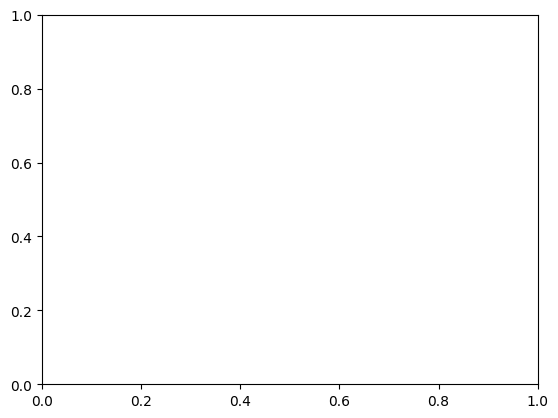

In [15]:
import matplotlib.pyplot as plt

epochs = 3
batch_size = 2
optimizer = AdamW(encoder.parameters(), lr=5e-5)
loss_func = nn.CrossEntropyLoss()
losses = []
for epoch in range(epochs):
    encoder.train()
    for idx, data in tqdm(enumerate(dataloader), total=int(len(dataset)/batch_size)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        labels = labels.view(-1)  

        predicted_labels = encoder(input_ids, attention_mask)
        loss = loss_func(predicted_labels, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss)

    print(f"Epoch {epoch + 1} of {epochs}")
    print(f"Generator loss: {loss:.8f}, Discriminator loss: {loss:.8f}")

plt.plot(losses)